In [2]:
# ---- Step 1: LOAD & CLEAN ----
import pandas as pd
import numpy as np

# Display tweaks (optional)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", 120)

# Load
df = pd.read_csv("compressed_data.csv", low_memory=False)
print("Shape:", df.shape)

# Ensure expected columns exist
needed = ["price", "service fee"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Clean price / service fee only if needed
for col in ["price", "service fee"]:
    if df[col].dtype == "object":
        df[col] = df[col].replace(r"[\$,]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill remaining price / service fee NAs with medians
for col in ["price", "service fee"]:
    df[col] = df[col].fillna(df[col].median())

# Optional: drop very sparse free-text column
if "house_rules" in df.columns:
    na_rate = df["house_rules"].isna().mean()
    if na_rate > 0.5:
        df = df.drop(columns=["house_rules"])

print("\nCleaned columns/dtypes:")
print(df.dtypes)

print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nPrice/Service fee summary:")
print(df[["price", "service fee"]].describe())


Shape: (102599, 26)

Cleaned columns/dtypes:
id                                  int64
NAME                               object
host id                             int64
host_identity_verified             object
host name                          object
neighbourhood group                object
neighbourhood                      object
lat                               float64
long                              float64
country                            object
country code                       object
instant_bookable                   object
cancellation_policy                object
room type                          object
Construction year                 float64
price                             float64
service fee                       float64
minimum nights                    float64
number of reviews                 float64
last review                        object
reviews per month                 float64
review rate number                float64
calculated host listings count 

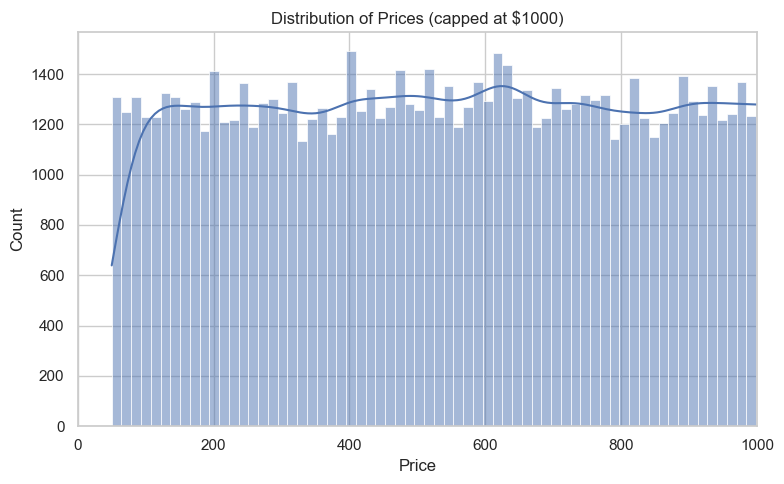

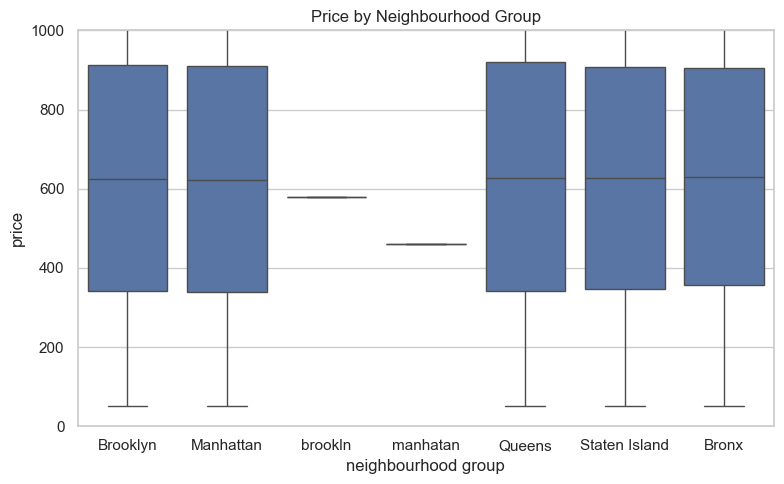

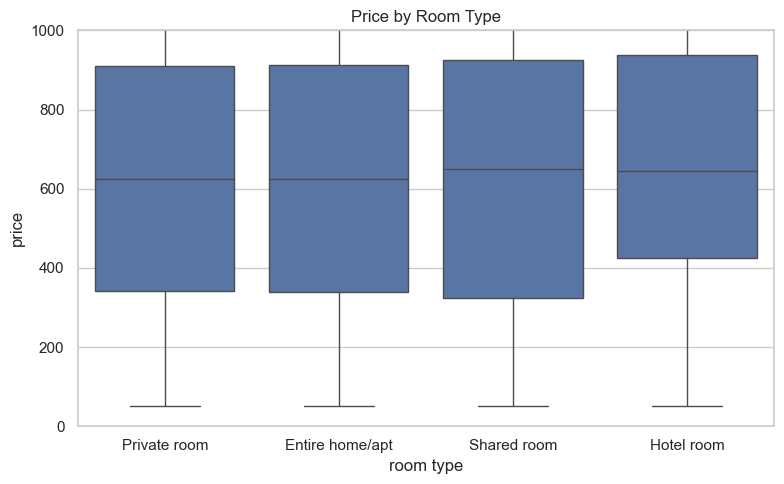

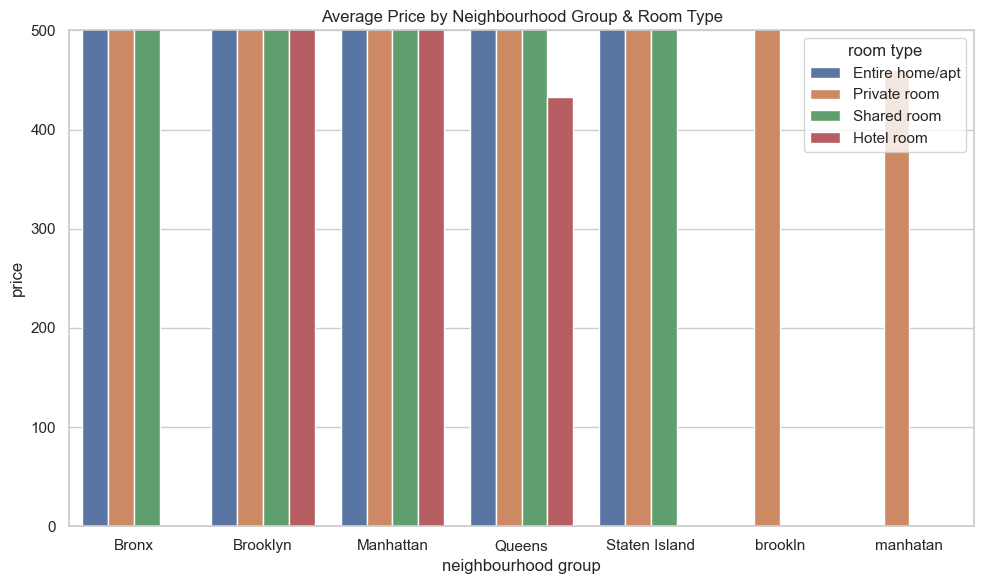

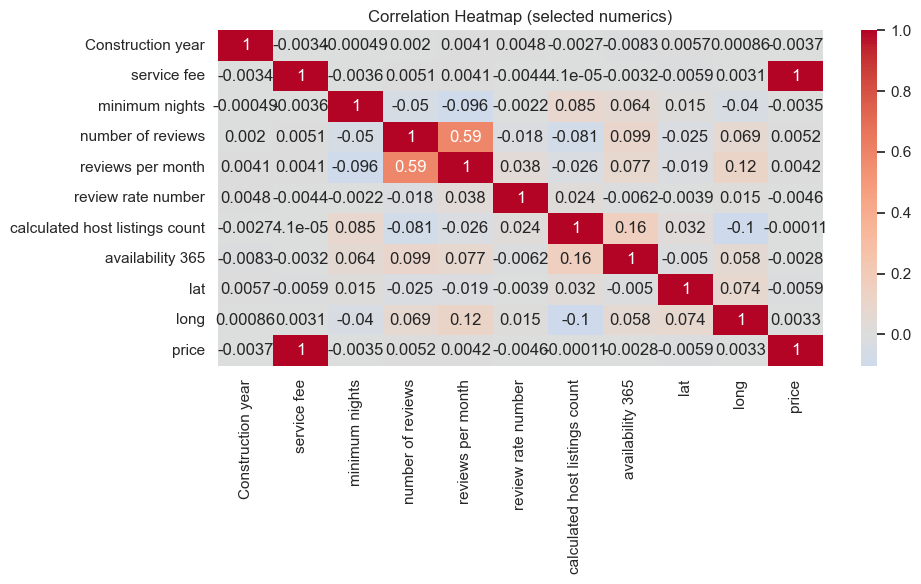

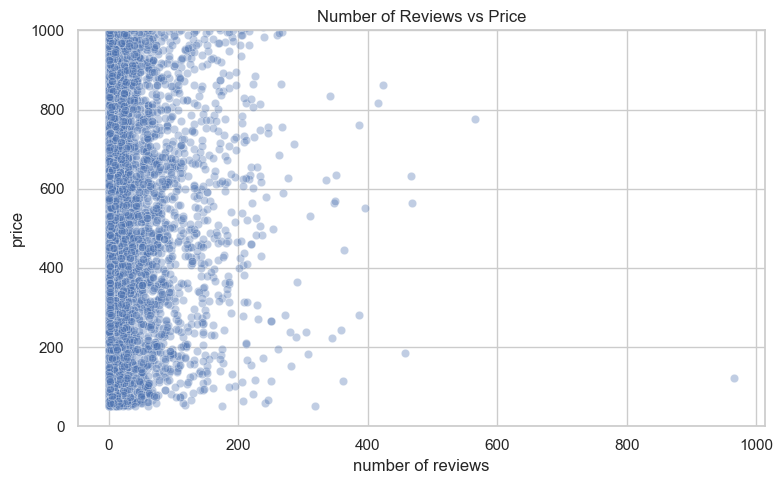

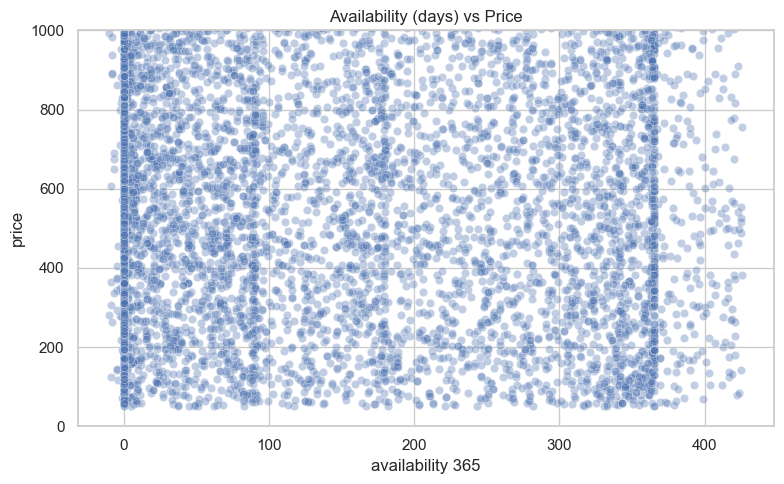

In [3]:
# ---- Step 2: EDA VISUALS ----
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

NG = "neighbourhood group"
RT = "room type"

# 2.1 Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=80, kde=True)
plt.xlim(0, 1000)
plt.title("Distribution of Prices (capped at $1000)")
plt.xlabel("Price"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# 2.2 Price by neighbourhood group
if NG in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=NG, y="price", data=df)
    plt.ylim(0, 1000)
    plt.title("Price by Neighbourhood Group")
    plt.tight_layout(); plt.show()

# 2.3 Price by room type
if RT in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=RT, y="price", data=df)
    plt.ylim(0, 1000)
    plt.title("Price by Room Type")
    plt.tight_layout(); plt.show()

# 2.4 Average price by neighbourhood group × room type
if NG in df.columns and RT in df.columns:
    plt.figure(figsize=(10,6))
    grp = df.groupby([NG, RT])["price"].mean().reset_index()
    sns.barplot(x=NG, y="price", hue=RT, data=grp, estimator="mean")
    plt.ylim(0, 500)
    plt.title("Average Price by Neighbourhood Group & Room Type")
    plt.tight_layout(); plt.show()

# 2.5 Correlation heatmap (selected numeric)
num_cols = [
    "Construction year", "service fee", "minimum nights", "number of reviews",
    "reviews per month", "review rate number", "calculated host listings count",
    "availability 365", "lat", "long", "price"
]
num_cols = [c for c in num_cols if c in df.columns]
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(numeric_only=True), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (selected numerics)")
plt.tight_layout(); plt.show()

# 2.6 Reviews vs price
if "number of reviews" in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df.sample(min(len(df), 8000), random_state=42),
                    x="number of reviews", y="price", alpha=0.35)
    plt.ylim(0, 1000); plt.title("Number of Reviews vs Price")
    plt.tight_layout(); plt.show()

# 2.7 Availability vs price
if "availability 365" in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df.sample(min(len(df), 8000), random_state=42),
                    x="availability 365", y="price", alpha=0.35)
    plt.ylim(0, 1000); plt.title("Availability (days) vs Price")
    plt.tight_layout(); plt.show()


In [4]:
# ---- Step 3: HANDLE MISSING VALUES + FEATURE ENGINEERING ----
from sklearn.preprocessing import LabelEncoder

# 3.1 Drop columns that are too sparse
if "license" in df.columns:
    df = df.drop(columns=["license"])   # ~100% missing

# 3.2 Handle 'last review' (convert to datetime + extract features)
if "last review" in df.columns:
    df["last review"] = pd.to_datetime(df["last review"], errors="coerce")
    df["last_review_year"] = df["last review"].dt.year.fillna(0).astype(int)
    df["last_review_month"] = df["last review"].dt.month.fillna(0).astype(int)
    df = df.drop(columns=["last review"])

# 3.3 Fill categorical NAs with "Unknown"
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

# 3.4 Fill numerical NAs with 0 (if logical) or median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if df[col].isna().sum() > 0:
        # special handling for review-related columns
        if "review" in col or "reviews" in col:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(df[col].median())

# 3.5 Example new feature: total cost (price + service fee)
if "price" in df.columns and "service fee" in df.columns:
    df["total_cost"] = df["price"] + df["service fee"]

# 3.6 Simplify categorical variables if too many unique values
# Example: host name has thousands of unique entries -> drop
if "host name" in df.columns:
    df = df.drop(columns=["host name"])

# 3.7 Encode binary columns (Yes/No style)
if "host_identity_verified" in df.columns:
    df["host_identity_verified"] = df["host_identity_verified"].map(
        {"t": 1, "f": 0, "Unknown": 0}
    )

if "instant_bookable" in df.columns:
    df["instant_bookable"] = df["instant_bookable"].map(
        {"t": 1, "f": 0, "Unknown": 0}
    )

print("\n✅ After cleaning & feature engineering:")
print(df.info())
print("\nMissing values left:")
print(df.isna().sum().sum())
print("\nSample rows:")
print(df.head(3))



✅ After cleaning & feature engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102599 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          289 non-null     float64
 4   neighbourhood group             102599 non-null  object 
 5   neighbourhood                   102599 non-null  object 
 6   lat                             102599 non-null  float64
 7   long                            102599 non-null  float64
 8   country                         102599 non-null  object 
 9   country code                    102599 non-null  object 
 10  instant_bookable                105 non-null     float64
 11  cancellation_policy             10259

In [5]:
# ---- Fix binary columns & final missing cleanup ----

# Re-map host_identity_verified
if "host_identity_verified" in df.columns:
    df["host_identity_verified"] = df["host_identity_verified"].replace(
        {"t": 1, "f": 0, "Unknown": 0}
    ).fillna(0).astype(int)

# Re-map instant_bookable
if "instant_bookable" in df.columns:
    df["instant_bookable"] = df["instant_bookable"].replace(
        {"t": 1, "f": 0, "Unknown": 0}
    ).fillna(0).astype(int)

# Final sweep: fill any remaining categorical NAs with "Unknown"
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

# Final sweep: fill any remaining numeric NAs with median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

print("\n✅ Dataset fully cleaned:")
print(df.info())
print("\nRemaining missing values:", df.isna().sum().sum())



✅ Dataset fully cleaned:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102599 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102599 non-null  int64  
 4   neighbourhood group             102599 non-null  object 
 5   neighbourhood                   102599 non-null  object 
 6   lat                             102599 non-null  float64
 7   long                            102599 non-null  float64
 8   country                         102599 non-null  object 
 9   country code                    102599 non-null  object 
 10  instant_bookable                102599 non-null  int64  
 11  cancellation_policy             102599 non-null  obj

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ---- Step 4: Feature/Target Split ----
drop_cols = ["id", "NAME", "host id", "total_cost"]  # ignore if missing
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Target variable
y = df_model["price"]

# Features
X = df_model.drop(columns=["price"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify categorical & numerical columns
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# ---- Step 5: Preprocessing Pipeline ----
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Baseline model: Linear Regression
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train model
model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Categorical columns: ['neighbourhood group', 'neighbourhood', 'country', 'country code', 'cancellation_policy', 'room type']
Numerical columns: ['host_identity_verified', 'lat', 'long', 'instant_bookable', 'Construction year', 'service fee', 'minimum nights', 'number of reviews', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365', 'last_review_year', 'last_review_month']
MAE: 2.8063639855431175
RMSE: 22.358335967299293


In [8]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Random Forest pipeline
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200, 
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

# XGBoost pipeline
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Train & evaluate each model
models = {
    "Linear Regression": model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, m in models.items():
    print(f"\n🔹 Training {name}...")
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


🔹 Training Linear Regression...
Linear Regression - MAE: 2.81, RMSE: 22.36

🔹 Training Random Forest...
Random Forest - MAE: 2.88, RMSE: 23.46

🔹 Training XGBoost...
XGBoost - MAE: 4.25, RMSE: 24.20


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ✅ Reload dataset if not already in memory
# df = pd.read_csv("cleaned_dataset.csv")

# ✅ Define features & target
X = df.drop(columns=["total_cost", "id", "NAME", "host id"])
y = df["total_cost"]

# ✅ Use a smaller sample for speed (optional)
X_small = X.sample(20000, random_state=42)   # reduce if still slow
y_small = y.loc[X_small.index]

# ✅ Define categorical & numerical columns
categorical = ['neighbourhood group', 'neighbourhood', 'country', 'country code',
               'cancellation_policy', 'room type']
numerical = ['host_identity_verified', 'lat', 'long', 'instant_bookable',
             'Construction year', 'service fee', 'minimum nights',
             'number of reviews', 'reviews per month', 'review rate number',
             'calculated host listings count', 'availability 365',
             'last_review_year', 'last_review_month']

# ✅ Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical)
    ]
)

# ✅ Define models with fewer trees (faster)
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1, verbosity=0)
}

# ✅ Cross-validation with fewer folds (faster)
results_cv = {}
for name, model in models.items():
    print(f"\n🔹 Cross-validating {name}...")
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    mae_scores = -cross_val_score(pipeline, X_small, y_small,
                                  cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
    rmse_scores = np.sqrt(-cross_val_score(pipeline, X_small, y_small,
                                           cv=3, scoring="neg_mean_squared_error", n_jobs=-1))

    results_cv[name] = {
        "MAE Mean": np.mean(mae_scores),
        "MAE Std": np.std(mae_scores),
        "RMSE Mean": np.mean(rmse_scores),
        "RMSE Std": np.std(rmse_scores)
    }

print("\n✅ Cross-validation results (fast test):")
print(results_cv)



🔹 Cross-validating Linear Regression...

🔹 Cross-validating Random Forest...

🔹 Cross-validating XGBoost...

✅ Cross-validation results (fast test):
{'Linear Regression': {'MAE Mean': np.float64(3.1600750205286148), 'MAE Std': np.float64(0.20475332968640225), 'RMSE Mean': np.float64(21.875715195432022), 'RMSE Std': np.float64(1.4651953837604967)}, 'Random Forest': {'MAE Mean': np.float64(3.4786835670217684), 'MAE Std': np.float64(0.16140527419607284), 'RMSE Mean': np.float64(23.33601971948734), 'RMSE Std': np.float64(1.2810091488831605)}, 'XGBoost': {'MAE Mean': np.float64(4.4555657915724565), 'MAE Std': np.float64(0.26432413673490845), 'RMSE Mean': np.float64(23.976073836364368), 'RMSE Std': np.float64(1.5990993623242264)}}


In [10]:
# If needed, (re)define X, y and the column lists
# X = df.drop(columns=["total_cost", "id", "NAME", "host id"], errors="ignore")
# y = df["total_cost"]

categorical = ['neighbourhood group', 'neighbourhood', 'country', 'country code',
               'cancellation_policy', 'room type']

numerical = ['host_identity_verified', 'lat', 'long', 'instant_bookable',
             'Construction year', 'service fee', 'minimum nights',
             'number of reviews', 'reviews per month', 'review rate number',
             'calculated host listings count', 'availability 365',
             'last_review_year', 'last_review_month']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical)
    ]
)


In [13]:
# Sample ~20% of the TRAINING set for faster RandomizedSearch
SAMPLE_FRAC = 0.20   # tweak to 0.1 if still slow
X_tune = X_train.sample(frac=SAMPLE_FRAC, random_state=42)
y_tune = y_train.loc[X_tune.index]


In [14]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_param_dist = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 10, 15, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5]
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=20,             # reduce to 10 if slow; increase to 30 for better search
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_tune, y_tune)
print("RF best MAE (CV, neg):", rf_search.best_score_)
print("RF best params:", rf_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
RF best MAE (CV, neg): -4.2702055311890845
RF best params: {'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None}


In [15]:
from xgboost import XGBRegressor

xgb_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",   # MUCH faster on CPU
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ))
])

xgb_param_dist = {
    "model__n_estimators": [200, 300, 500],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [4, 6, 8],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__reg_alpha": [0, 0.1, 0.5],
    "model__reg_lambda": [1.0, 1.5, 2.0]
}

xgb_search = RandomizedSearchCV(
    xgb_pipe,
    xgb_param_dist,
    n_iter=20,            # reduce to 10 if slow; increase to 30 for better search
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(X_tune, y_tune)
print("XGB best MAE (CV, neg):", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGB best MAE (CV, neg): -3.274052508393226
XGB best params: {'model__subsample': 0.7, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 200, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 1. Define preprocessing
categorical = X.select_dtypes(include="object").columns
numerical = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical)
    ]
)

# 2. Define RF + XGB pipelines
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=42, n_jobs=-1))
])

# 3. Random Forest param grid
param_grid_rf = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 10, 20],
    "model__max_features": ["sqrt", 0.5],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

# 4. XGB param grid
param_grid_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 4, 6],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.7, 1.0],
    "model__colsample_bytree": [0.7, 1.0],
    "model__reg_alpha": [0, 0.5],
    "model__reg_lambda": [1, 2]
}

# 5. Run GridSearchCV
grid_rf = GridSearchCV(rf_pipeline, param_grid=param_grid_rf,
                       cv=3, scoring="neg_mean_absolute_error", 
                       n_jobs=-1, verbose=1)

grid_xgb = GridSearchCV(xgb_pipeline, param_grid=param_grid_xgb,
                        cv=3, scoring="neg_mean_absolute_error", 
                        n_jobs=-1, verbose=1)

print("🔹 Tuning Random Forest...")
grid_rf.fit(X_train, y_train)
print("RF best MAE (CV, neg):", grid_rf.best_score_)
print("RF best params:", grid_rf.best_params_)

print("\n🔹 Tuning XGBoost...")
grid_xgb.fit(X_train, y_train)
print("XGB best MAE (CV, neg):", grid_xgb.best_score_)
print("XGB best params:", grid_xgb.best_params_)`


🔹 Tuning Random Forest...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
RF best MAE (CV, neg): -0.2271745882628239
RF best params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500}

🔹 Tuning XGBoost...
Fitting 3 folds for each of 192 candidates, totalling 576 fits
XGB best MAE (CV, neg): -0.8194317606206973
XGB best params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__reg_alpha': 0.5, 'model__reg_lambda': 1, 'model__subsample': 1.0}


In [19]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Random Forest ---
start = time.time()
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_test)
end = time.time()

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print(f"✅ Random Forest trained & evaluated in {end - start:.2f} sec")

# --- XGBoost ---
start = time.time()
best_xgb = grid_xgb.best_estimator_
best_xgb.fit(X_train, y_train)
xgb_pred = best_xgb.predict(X_test)
end = time.time()

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"✅ XGBoost trained & evaluated in {end - start:.2f} sec")

# --- Compare results ---
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [rf_mae, xgb_mae],
    "RMSE": [rf_rmse, xgb_rmse],
    "R2": [rf_r2, xgb_r2]
})
print("\n📊 Final Test Set Results:")
print(results)


✅ Random Forest trained & evaluated in 2301.88 sec
✅ XGBoost trained & evaluated in 2.34 sec

📊 Final Test Set Results:
           Model       MAE      RMSE        R2
0  Random Forest  0.163493  0.762964  0.999996
1        XGBoost  0.834665  1.047412  0.999993


In [20]:
# Save cleaned dataset
df.to_csv("cleaned_dataset.csv", index=False)
print("✅ Cleaned dataset saved as cleaned_dataset.csv")


✅ Cleaned dataset saved as cleaned_dataset.csv


In [21]:
import joblib

# Save trained models
joblib.dump(best_rf, "best_random_forest.pkl")
joblib.dump(best_xgb, "best_xgboost.pkl")

print("✅ Models saved as best_random_forest.pkl and best_xgboost.pkl")


✅ Models saved as best_random_forest.pkl and best_xgboost.pkl


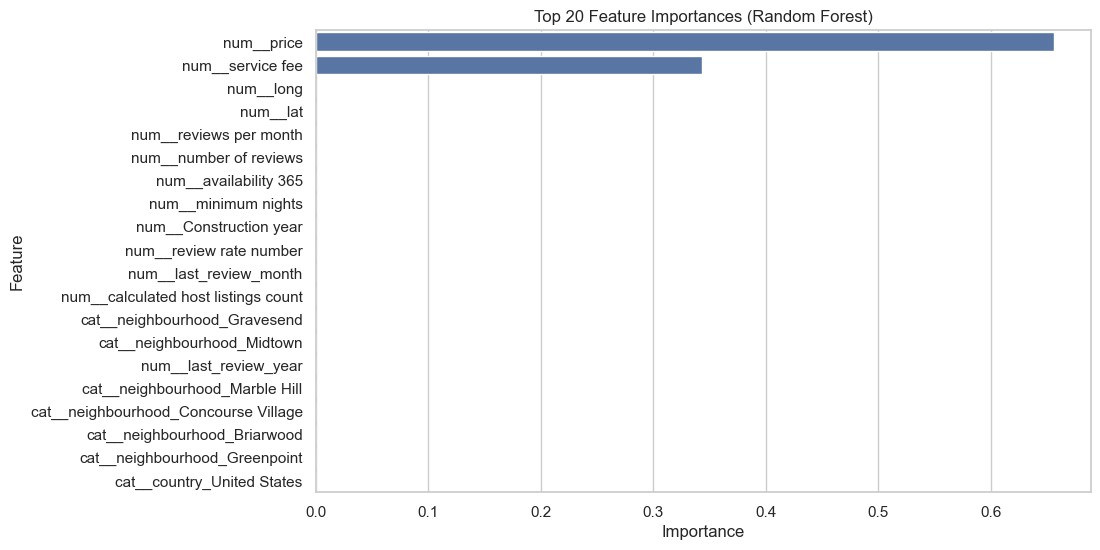

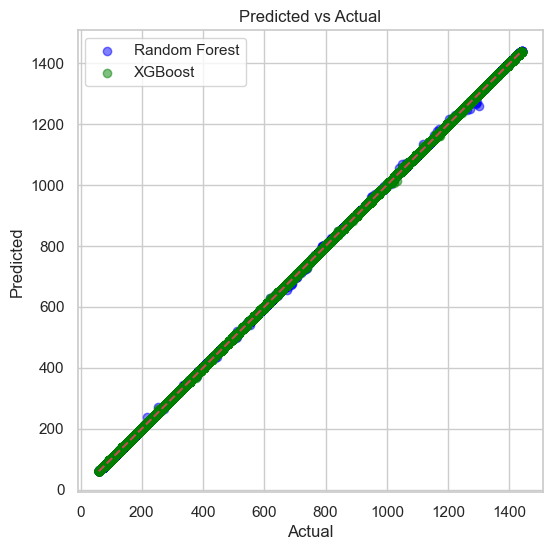

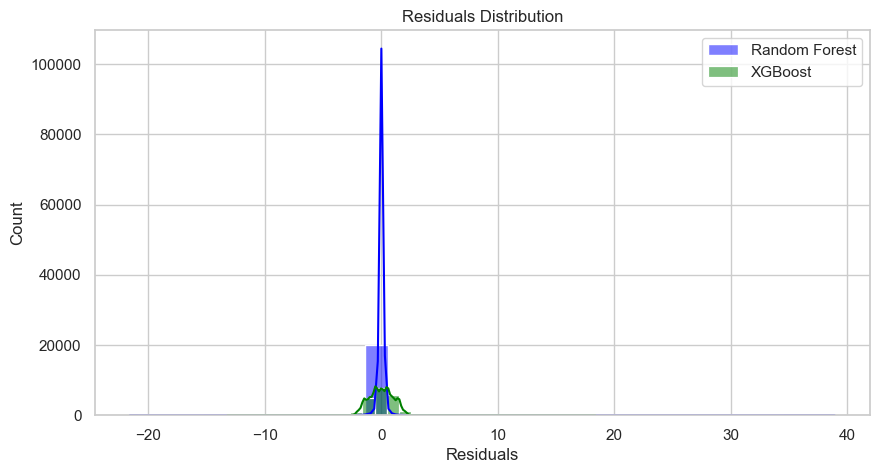

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Importance (Random Forest) ---
rf_importances = best_rf.named_steps["model"].feature_importances_
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()
importances = pd.Series(rf_importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --- Predicted vs Actual ---
rf_preds = best_rf.predict(X_test)
xgb_preds = best_xgb.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_preds, alpha=0.5, label="Random Forest", color="blue")
plt.scatter(y_test, xgb_preds, alpha=0.5, label="XGBoost", color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.legend()
plt.show()

# --- Residuals ---
rf_residuals = y_test - rf_preds
xgb_residuals = y_test - xgb_preds

plt.figure(figsize=(10,5))
sns.histplot(rf_residuals, bins=30, color="blue", kde=True, label="Random Forest")
sns.histplot(xgb_residuals, bins=30, color="green", kde=True, label="XGBoost")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.legend()
plt.show()


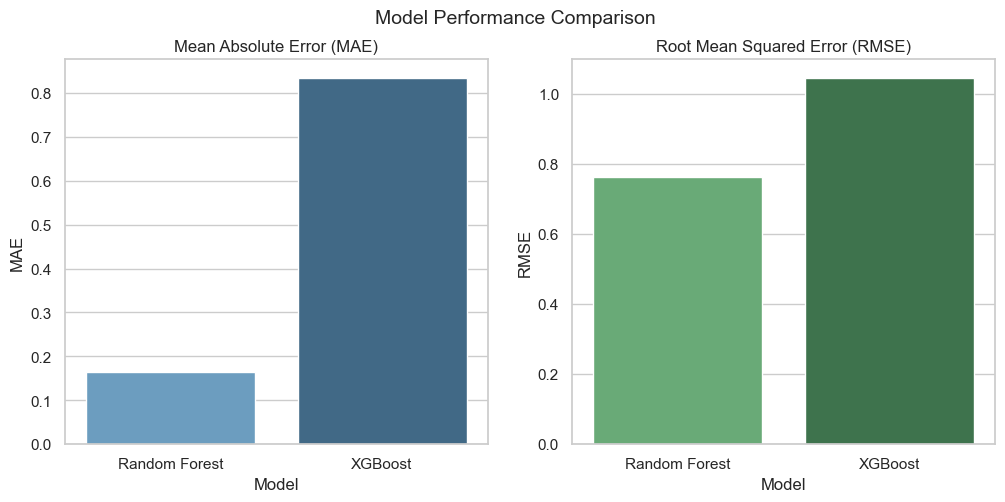

In [24]:
# Model comparison dataframe
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [0.163493, 0.834665],
    "RMSE": [0.762964, 1.047412],
    "R2": [0.999996, 0.999993]
})

# --- Bar plot for MAE & RMSE (fixed future warning) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=results_df, x="Model", y="MAE", ax=axes[0], hue="Model", dodge=False, palette="Blues_d", legend=False)
axes[0].set_title("Mean Absolute Error (MAE)")

sns.barplot(data=results_df, x="Model", y="RMSE", ax=axes[1], hue="Model", dodge=False, palette="Greens_d", legend=False)
axes[1].set_title("Root Mean Squared Error (RMSE)")

plt.suptitle("Model Performance Comparison", fontsize=14)
plt.show()



In [25]:
import sklearn
import joblib

print("scikit-learn version:", sklearn.__version__)
print("joblib version:", joblib.__version__)



scikit-learn version: 1.6.1
joblib version: 1.4.2


In [26]:
import xgboost
print(xgboost.__version__)


3.0.4


In [28]:
df.head()
df.columns


Index(['id', 'NAME', 'host id', 'host_identity_verified', 'neighbourhood group', 'neighbourhood', 'lat', 'long',
       'country', 'country code', 'instant_bookable', 'cancellation_policy', 'room type', 'Construction year', 'price',
       'service fee', 'minimum nights', 'number of reviews', 'reviews per month', 'review rate number',
       'calculated host listings count', 'availability 365', 'last_review_year', 'last_review_month', 'total_cost'],
      dtype='object')